In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
import glob
from torchvision import transforms
from torch.utils import data
from PIL import Image

In [2]:
img_dir = r'./dataset2/*.jpg'

In [3]:
imgs = glob.glob(img_dir)

In [4]:
imgs[:3]

['./dataset2\\cloudy1.jpg',
 './dataset2\\cloudy10.jpg',
 './dataset2\\cloudy100.jpg']

In [5]:
species = ['cloudy', 'rain', 'shine', 'sunrise']

In [6]:
species_to_idx = dict((c, i) for i, c in enumerate(species))

In [7]:
species_to_idx

{'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3}

In [8]:
idx_to_species = dict((v, k) for k, v in species_to_idx.items())

In [9]:
idx_to_species

{0: 'cloudy', 1: 'rain', 2: 'shine', 3: 'sunrise'}

In [10]:
labels = []
for img in imgs:
    for i, c in enumerate(species):
        if c in img:
            labels.append(i)

In [11]:
labels[:3]

[0, 0, 0]

In [12]:
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])

In [13]:
class WT_dataset(data.Dataset):
    def __init__(self, imgs_path, lables):
        self.imgs_path = imgs_path
        self.lables = lables

    def __getitem__(self, index):
        img_path = self.imgs_path[index]
        lable = self.lables[index]
        
        pil_img = Image.open(img_path)
        pil_img = pil_img.convert("RGB")
        pil_img = transforms(pil_img)
        return pil_img, lable

    def __len__(self):
        return len(self.imgs_path)

In [14]:
dataset = WT_dataset(imgs, labels)

In [15]:
count = len(dataset)
print(count)

1122


In [16]:
train_count = int(0.8*count)
test_count = count - train_count
train_dataset, test_dataset = data.random_split(dataset, [train_count, test_count])
print(len(train_dataset), len(test_dataset))

897 225


In [17]:
BTACH_SIZE = 16

In [18]:
train_dl = torch.utils.data.DataLoader(
                                       train_dataset,
                                       batch_size=BTACH_SIZE,
                                       shuffle=True
)

In [19]:
test_dl = torch.utils.data.DataLoader(
                                       test_dataset,
                                       batch_size=BTACH_SIZE,
)

In [20]:
imgs, labels = next(iter(train_dl))

In [21]:
imgs.shape

torch.Size([16, 3, 224, 224])

In [22]:
imgs[0].shape

torch.Size([3, 224, 224])

In [23]:
im = imgs[0].permute(1, 2, 0)

In [24]:
im.shape

torch.Size([224, 224, 3])

In [25]:
im = im.numpy()

In [26]:
type(im)

numpy.ndarray

In [27]:
im.shape

(224, 224, 3)

In [28]:
im.max(), im.min()

(1.0, -0.7411765)

In [29]:
im = (im + 1)/2

In [30]:
im.max(), im.min()

(1.0, 0.12941176)

Text(0.5, 1.0, 'shine')

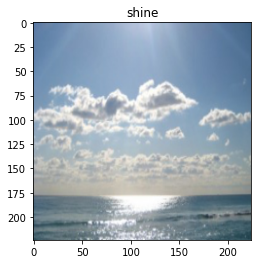

In [31]:
plt.imshow(im)
plt.title(idx_to_species[labels[0].item()])

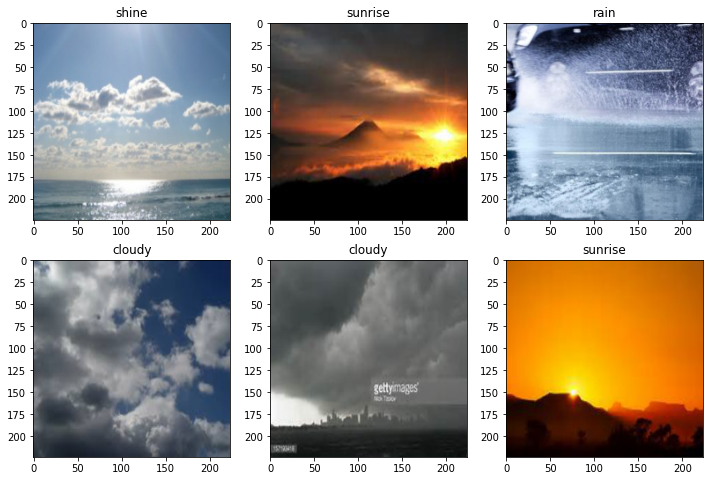

In [32]:
plt.figure(figsize=(12, 8))
for i, (img, label) in enumerate(zip(imgs[:6], labels[:6])):
    img = (img.permute(1, 2, 0).numpy() + 1)/2
    plt.subplot(2, 3, i+1)
    plt.title(idx_to_species.get(label.item()))
    plt.imshow(img)

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


# 使用VGG预训练模型

In [34]:
model = torchvision.models.vgg16(pretrained=True)

In [35]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [36]:
for param in model.features.parameters():
    param.requires_grad = False

In [37]:
model.classifier[-1].out_features = 4

In [38]:
model = model.to(device)

# 训练代码

In [39]:
loss_fn = nn.CrossEntropyLoss()

In [40]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [41]:
#此处使用训练代码

In [42]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            train_loss += loss.item()
    train_loss /= num_batches
    correct /= size
    return train_loss, correct

In [43]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size

    return test_loss, correct

In [44]:
epochs = 10

In [45]:
def fit(epochs, train_dl, test_dl, model, loss_fn, optimizer):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    for epoch in range(epochs):
        epoch_loss, epoch_acc = train(train_dl, model, loss_fn, optimizer)
        epoch_test_loss, epoch_test_acc = test(test_dl, model)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc)
    
        template = ("epoch:{:2d}, train_loss: {:.5f}, train_acc: {:.1f}% ," 
                    "test_loss: {:.5f}, test_acc: {:.1f}%")
        print(template.format(
              epoch, epoch_loss, epoch_acc*100, epoch_test_loss, epoch_test_acc*100))
    print("Done!")
    
    return train_loss, test_loss, train_acc, test_acc

In [46]:
train_loss, test_loss, train_acc, test_acc = fit(epochs, 
                                                 train_dl, 
                                                 test_dl, 
                                                 model, 
                                                 loss_fn, 
                                                 optimizer)

C:\Users\guanghua\miniconda3\envs\tch19\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch: 0, train_loss: 1.03941, train_acc: 75.5% ,test_loss: 0.17370, test_acc: 93.3%
epoch: 1, train_loss: 0.06119, train_acc: 98.0% ,test_loss: 0.13293, test_acc: 96.0%
epoch: 2, train_loss: 0.01446, train_acc: 99.7% ,test_loss: 0.12391, test_acc: 95.1%
epoch: 3, train_loss: 0.01365, train_acc: 99.6% ,test_loss: 0.17494, test_acc: 95.6%
epoch: 4, train_loss: 0.00413, train_acc: 100.0% ,test_loss: 0.14284, test_acc: 96.4%
epoch: 5, train_loss: 0.00239, train_acc: 99.9% ,test_loss: 0.13076, test_acc: 96.9%
epoch: 6, train_loss: 0.00062, train_acc: 100.0% ,test_loss: 0.12674, test_acc: 96.4%
epoch: 7, train_loss: 0.00039, train_acc: 100.0% ,test_loss: 0.12890, test_acc: 96.0%
epoch: 8, train_loss: 0.00033, train_acc: 100.0% ,test_loss: 0.13776, test_acc: 96.4%
epoch: 9, train_loss: 0.00027, train_acc: 100.0% ,test_loss: 0.15708, test_acc: 95.1%
Done!


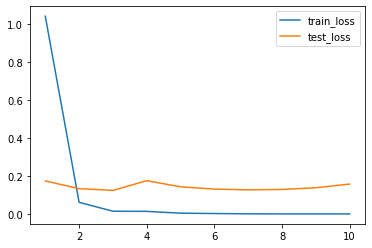

In [47]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()

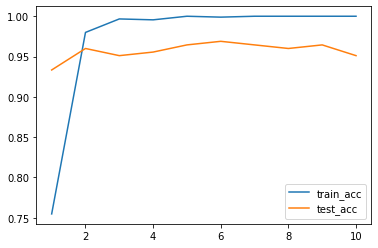

In [48]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()